<a href="https://colab.research.google.com/github/ingredy3/SSD_1/blob/main/Vfinal_MVP_car_prices_full_detalhado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP — Predição de Preço de Veículos Usados
**Disciplina:** Sistemas de Suporte à Decisão  
**Aluno(a):** Ingredy Thamis  
**Data:** 29 de Setembro de 2025

---

## 1. Definição do Problema
O objetivo deste trabalho é construir um **MVP** (Produto Mínimo Viável) de um sistema de suporte à decisão que seja capaz de **estimar o preço de venda de veículos usados (`sellingprice`)** com base em características observáveis como ano de fabricação, quilometragem, condição, marca, modelo, etc.

---

## 2. Hipótese
- Hipótese principal: variáveis como idade do carro, quilometragem, marca/modelo e condição são capazes de explicar boa parte da variação do preço.
- Hipótese adicional: a variável `mmr` apresenta **data leakage** (correlação ≈ 0.98 com o preço), portanto não deve ser utilizada no modelo final.

---

## 3. Conjunto de Dados
- Arquivo: `car_prices.csv` (reduzido para ~150.000 registros e hospedado no GitHub).
- Variável alvo: `sellingprice` (valor de venda do veículo).
- Principais variáveis utilizadas: `year`, `make`, `model`, `body`, `transmission`, `condition`, `odometer`, `color`, `interior`, `state`, `vehicle_age`.

---

## 4. Metodologia
O processo foi dividido em etapas:
1. Importação das bibliotecas.
2. Carregamento e amostragem do dataset.
3. Criação da variável `vehicle_age`.
4. Limpeza de dados (ex.: `odometer`).
5. Redução de cardinalidade em variáveis categóricas.
6. Pré-processamento (imputação, normalização e One-Hot Encoding).
7. Teste de modelos: Baseline, Regressão Linear, Random Forest.
8. Avaliação por métricas (MAE, RMSE, R²).
9. Análise de importância de variáveis.

## Passo 1 — Importar bibliotecas

**O que vamos fazer:** importar as bibliotecas necessárias para manipulação de dados, construção de modelos, métricas e visualização.

**Por que:** ter todas as dependências carregadas no início evita erros e facilita a reprodução (Colab, Jupyter).

In [115]:

# Passo 1 - importar bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import joblib
import warnings
warnings.filterwarnings('ignore')

print('Bibliotecas carregadas com sucesso.')


Bibliotecas carregadas com sucesso.


**Interpretação / Observação:** se aparecer erro ao executar esta célula no Colab, verifique se o ambiente tem scikit-learn instalado (versão compatível).

## Passo 2 — Carregar a base de dados

**O que vamos fazer:** carregar o CSV hospedado no GitHub (raw URL).

**Por que:** ter o dataset disponível em `df` para análise e modelagem.

**Atenção:** substitua a URL se quiser usar outra versão do arquivo.

In [116]:

# Passo 2 - carregar dados
url = "https://raw.githubusercontent.com/ingredy3/SSD_1/refs/heads/main/car_prices.csv"  # ajuste se necessário
df = pd.read_csv(url)
print("Shape do dataset:", df.shape)
df.head(5)


Shape do dataset: (149999, 16)


,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800,21500,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900,30000,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500,27750,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000,67000,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


**Interpretação:** após rodar a célula, confirme o tamanho do dataset (linhas x colunas) e veja as primeiras linhas para garantir que a leitura foi correta.

## Passo 3 — Exploração inicial (EDA)

**O que vamos fazer:** inspecionar tipos, estatísticas descritivas e contagem de valores nulos.

**Por que:** identificar problemas iniciais (nulos, tipos errados, outliers) que precisam ser tratados antes de modelar.

In [117]:

# Passo 3 - EDA rápida
print('Informações gerais:')
display(df.info())
print('\nEstatísticas descritivas (numéricas):')
display(df.describe())
print('\nContagem de nulos por coluna (top 30):')
display(df.isnull().sum().sort_values(ascending=False).head(30))


Informações gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149999 entries, 0 to 149998
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          149999 non-null  int64  
 1   make          148858 non-null  object 
 2   model         148830 non-null  object 
 3   trim          148529 non-null  object 
 4   body          145985 non-null  object 
 5   transmission  132413 non-null  object 
 6   vin           149999 non-null  object 
 7   state         149999 non-null  object 
 8   condition     138207 non-null  float64
 9   odometer      149922 non-null  float64
 10  color         149742 non-null  object 
 11  interior      149742 non-null  object 
 12  seller        149999 non-null  object 
 13  mmr           149999 non-null  int64  
 14  sellingprice  149999 non-null  int64  
 15  saledate      149999 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 18.3+ MB


None


Estatísticas descritivas (numéricas):


,year,condition,odometer,mmr,sellingprice
count,149999.000000,138207.000000,149922.000000,149999.000000,149999.000000
mean,2009.470816,29.825450,73130.641093,12926.552010,12646.444810
std,4.182271,13.757659,56617.981749,9480.305488,9526.933281
min,1984.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,22.000000,28877.250000,5850.000000,5500.000000
50%,2011.000000,34.000000,58006.000000,11650.000000,11300.000000
75%,2013.000000,41.000000,107773.250000,17450.000000,17300.000000
max,2015.000000,49.000000,999999.000000,176000.000000,169500.000000



Contagem de nulos por coluna (top 30):


,0
transmission,17586
condition,11792
body,4014
trim,1470
model,1169
make,1141
color,257
interior,257
odometer,77
state,0


**Interpretação:** veja quais colunas têm muitos valores faltantes e anote colunas do tipo `object` (categóricas) e `int/float` (numéricas).

## Passo 4 — Checar correlação `mmr` x `sellingprice` (justificativa de remoção)

**O que vamos fazer:** calcular a correlação entre `mmr` e `sellingprice` para verificar se existe vazamento de informação (data leakage).

**Por que:** se `mmr` estiver altamente correlacionada com `sellingprice`, incluí-la no treino faz o modelo "colar" na resposta e produzir métricas otimistas mas irreais.

In [118]:

# Passo 4 - correlação entre mmr e sellingprice (se existirem)
if 'mmr' in df.columns and 'sellingprice' in df.columns:
    corr = df[['mmr','sellingprice']].dropna().corr().iloc[0,1]
    print("Correlação (Pearson) mmr x sellingprice: ", corr)
else:
    print("Coluna 'mmr' não encontrada na base ou 'sellingprice' ausente.")


Correlação (Pearson) mmr x sellingprice:  0.9825172278701101


**Interpretação:** se a correlação for muito alta (ex.: ~0.98), isso indica forte vazamento — então não usaremos `mmr` no modelo final.

## Passo 5 — Amostragem e seleção de colunas (removendo `mmr`)

**O que vamos fazer:** reduzir para 10% da base (teste rápido) e escolher colunas relevantes **sem** `mmr`.

**Por que:** amostragem acelera desenvolvimento; remover `mmr` evita data leakage.

In [119]:

# Passo 5 - amostragem 10%
RANDOM_STATE = 42
df = df.sample(frac=0.1, random_state=RANDOM_STATE).reset_index(drop=True)
print("Shape da amostra:", df.shape)

# Seleção de colunas (sem mmr)
candidate_cols = [
    "year", "make", "model", "body", "transmission",
    "condition", "odometer", "color", "interior", "state"
]
cols = [c for c in candidate_cols if c in df.columns]
target = "sellingprice"
df = df[cols + [target]].copy()
print("Shape após seleção de colunas:", df.shape)
df.head(5)


Shape da amostra: (15000, 16)
Shape após seleção de colunas: (15000, 11)


,year,make,model,body,transmission,condition,odometer,color,interior,state,sellingprice
0,2002,Toyota,Camry,Sedan,automatic,19.0,185100.0,red,tan,fl,2700
1,2006,Pontiac,Grand Prix,Sedan,automatic,19.0,118061.0,red,black,fl,3300
2,2008,BMW,3 Series,Convertible,automatic,4.0,56765.0,white,beige,ca,17500
3,2012,Volkswagen,Jetta,Sedan,automatic,27.0,41015.0,black,black,ca,11250
4,2011,Ford,F-150,SuperCab,automatic,39.0,24766.0,—,black,tn,24000


**Interpretação:** confirme que `mmr` não está nas colunas selecionadas. A amostra agora tem ~10% do dataset original e as colunas escolhidas refletem atributos do veículo.

## Passo 6 — Criar a feature `vehicle_age`

**O que vamos fazer:** criar `vehicle_age = 2025 - year` e limitar valores fora de faixa.

**Por que:** idade é uma feature direta e interpretável que costuma explicar boa parte do preço.

In [120]:

# Passo 6 - criar vehicle_age
df['vehicle_age'] = 2025 - df['year']
df['vehicle_age'] = df['vehicle_age'].clip(lower=0, upper=100)
display(df[['year','vehicle_age']].head(8))


,year,vehicle_age
0,2002,23
1,2006,19
2,2008,17
3,2012,13
4,2011,14
5,2013,12
6,2014,11
7,2005,20


**Interpretação:** verifique os valores mínimos e máximos da `vehicle_age`. Caso apareçam idades absurdas, revise o campo `year` na base original.

## Passo 7 — Limpar `odometer` (quilometragem)

**O que vamos fazer:** considerar apenas quilometragens plausíveis (100 - 500000 km). Valores fora dessa faixa serão convertidos para `NaN` e imputados depois.

**Por que:** entradas erradas inflariam erro ou gerariam vieses.

In [121]:

# Passo 7 - tratar odometer
df['odometer'] = df['odometer'].where((df['odometer'] >= 100) & (df['odometer'] <= 500000))
df['odometer'].describe()


,odometer
count,14913.000000
mean,72525.051834
std,54803.073710
min,174.000000
25%,28831.000000
50%,57105.000000
75%,106917.000000
max,450825.000000


**Interpretação:** confira quantos `NaN` surgiram em `odometer` (isso será tratado na pipeline com imputação por mediana).

## Passo 8 — Criar dataset final para modelagem (`df_model`)

**O que vamos fazer:** montar `df_model` com as colunas selecionadas, features criadas, e remover linhas sem target.

**Por que:** garantir que o dataset esteja pronto para o pipeline de pré-processamento.

In [122]:

# Passo 8 - criar df_model
df_model = df[df[target].notna()].copy().reset_index(drop=True)
print("Shape final df_model:", df_model.shape)
df_model.head(5)


Shape final df_model: (15000, 12)


,year,make,model,body,transmission,condition,odometer,color,interior,state,sellingprice,vehicle_age
0,2002,Toyota,Camry,Sedan,automatic,19.0,185100.0,red,tan,fl,2700,23
1,2006,Pontiac,Grand Prix,Sedan,automatic,19.0,118061.0,red,black,fl,3300,19
2,2008,BMW,3 Series,Convertible,automatic,4.0,56765.0,white,beige,ca,17500,17
3,2012,Volkswagen,Jetta,Sedan,automatic,27.0,41015.0,black,black,ca,11250,13
4,2011,Ford,F-150,SuperCab,automatic,39.0,24766.0,—,black,tn,24000,14


**Interpretação:** `df_model` é a tabela que usaremos para modelagem; confirme contagem de linhas e colunas e verifique amostras aleatórias se desejar.

## Passo 9 — Reduzir cardinalidade em `make` e `model`

**O que vamos fazer:** manter apenas as 80 categorias mais frequentes em `make` e `model`, agrupando o restante como `'other'`.

**Por que:** evita criação excessiva de dummies (OneHot) que estoura memória/tempo.

In [123]:

# Passo 9 - reduzir cardinalidade
def keep_top_n(series, top_n=80):
    top = series.value_counts().nlargest(top_n).index
    return series.where(series.isin(top), other='other')

for c in ['model','make']:
    if c in df_model.columns:
        df_model[c] = keep_top_n(df_model[c], top_n=80)

# mostrar distribuição resumida
for c in ['make','model']:
    if c in df_model.columns:
        print('\nTop valores em', c, ':')
        print(df_model[c].value_counts().head(10))



Top valores em make :
make
Ford             2427
Chevrolet        1498
Nissan           1375
Toyota            999
Dodge             819
Honda             801
BMW               648
Hyundai           584
Mercedes-Benz     489
Chrysler          478
Name: count, dtype: int64

Top valores em model :
model
other       5120
Altima       488
F-150        354
Escape       341
Camry        308
Focus        283
Fusion       280
Accord       268
3 Series     266
Civic        229
Name: count, dtype: int64


**Interpretação:** após essa transformação, `make` e `model` terão no máximo 81 categorias (top N + 'other'), reduzindo dimensionalidade no OneHotEncoder.

## Passo 10 — Separar treino e teste

**O que vamos fazer:** dividir os dados em treino (80%) e teste (20%), com `random_state` fixo para reprodutibilidade.

**Por que:** testar desempenho em dados que o modelo não viu durante o treino.

In [124]:

# Passo 10 - split treino/teste
X = df_model.drop(columns=[target])
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Treino:", X_train.shape, "Teste:", X_test.shape)


Treino: (12000, 11) Teste: (3000, 11)


**Interpretação:** confirme as dimensões e, opcionalmente, verifique a distribuição do target em ambos os conjuntos para garantir que não houve viés de amostragem.

## Passo 11 — Pré-processamento (imputação, escala e codificação)

**O que vamos fazer:** criar pipelines separadas para colunas numéricas e categóricas e combiná-las com `ColumnTransformer`.

**Por que:** aplicar o mesmo fluxo de transformação ao treino e ao teste, evitando vazamento de dados.

In [125]:

# Passo 11 - identificar colunas numéricas e categóricas
num_cols = [c for c in df_model.select_dtypes(include=['int64','float64']).columns if c != target]
cat_cols = [c for c in df_model.select_dtypes(include=['object']).columns]

print("Colunas numéricas:", num_cols)
print("Colunas categóricas:", cat_cols)

# construir transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

print("Pré-processador criado.")


Colunas numéricas: ['year', 'condition', 'odometer', 'vehicle_age']
Colunas categóricas: ['make', 'model', 'body', 'transmission', 'color', 'interior', 'state']
Pré-processador criado.


**Interpretação:** `preprocessor` garante que os mesmos tratamentos (imputação/scaling/one-hot) sejam aplicados tanto ao treino quanto ao teste. Isso evita *data leakage* por transformação inconsistente.

## Passo 12 — Função de métricas

**O que vamos fazer:** definir uma função que retorna MAE, RMSE e R² para facilitar comparações entre modelos.

In [126]:

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

print("Função de métricas definida.")


Função de métricas definida.


**Interpretação:** essas três métricas cobrem erro médio (MAE), sensibilidade a outliers (RMSE) e capacidade explicativa (R²).

## Passo 13 — Modelo Baseline (DummyRegressor)

**O que vamos fazer:** treinar um modelo que prevê sempre a mediana do preço (baseline).

**Por que:** avaliar se modelos mais complexos realmente adicionam valor sobre a estratégia trivial.

In [127]:

# Passo 13 - baseline
dummy = DummyRegressor(strategy="median")
pipe_dummy = Pipeline(steps=[("pre", preprocessor), ("model", dummy)])
pipe_dummy.fit(X_train, y_train)
y_pred_dummy = pipe_dummy.predict(X_test)
metrics_dummy = regression_metrics(y_test, y_pred_dummy)
metrics_dummy


{'MAE': 6900.417,
 'RMSE': np.float64(9422.489556074517),
 'R2': -0.011812345836652582}

**Interpretação:** o baseline estabelece uma referência (ex.: MAE alto). Modelos mais sofisticados devem apresentar MAE e RMSE menores e R² maior que o baseline.

## Passo 14 — Regressão Linear

**O que vamos fazer:** treinar um modelo linear (LinearRegression).

**Por que:** é um bom ponto de partida e é facilmente interpretável.

In [128]:

# Passo 14 - regressão linear
lr = LinearRegression()
pipe_lr = Pipeline(steps=[("pre", preprocessor), ("model", lr)])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
metrics_lr = regression_metrics(y_test, y_pred_lr)
metrics_lr


{'MAE': 3218.67595437444,
 'RMSE': np.float64(4973.750484809213),
 'R2': 0.7180730235653299}

**Interpretação:** a regressão linear dará uma ideia se as relações entre features e preço podem ser aproximadas linearmente. Compare suas métricas com o baseline.

## Passo 15 — Random Forest (modelo final escolhido)

**O que vamos fazer:** treinar uma Random Forest com parâmetros iniciais (n_estimators=100, max_depth=12).

**Por que:** costuma performar bem em dados tabulares sem muito tunning.

In [129]:

# Passo 15 - Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
pipe_rf = Pipeline(steps=[("pre", preprocessor), ("model", rf)])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
metrics_rf = regression_metrics(y_test, y_pred_rf)
metrics_rf


{'MAE': 2892.5457079006906,
 'RMSE': np.float64(4678.242049632687),
 'R2': 0.7505784227829232}

**Interpretação (resultados):** o Random Forest foi o melhor modelo no experimento sem `mmr`. Métricas obtidas: **MAE = R$ 2.892,55**, **RMSE = R$ 4.678,24**, **R² = 0.7506**.

Esses números significam que, em média, o erro é ~R$2.900 e que o modelo explica ~75% da variação do preço. Valores maiores de R² e menores de MAE/RMSE indicam melhor desempenho.

## Passo 16 — Comparação entre modelos

**O que vamos fazer:** mostrar lado a lado as métricas do baseline, regressão linear e Random Forest.

In [130]:

# Passo 16 - tabela comparativa
results = pd.DataFrame([
    {"model":"Baseline (Dummy)", **metrics_dummy},
    {"model":"Linear Regression", **metrics_lr},
    {"model":"Random Forest", **metrics_rf},
]).set_index("model")

results_display = results.rename(columns={"MAE":"MAE (R$)","RMSE":"RMSE (R$)","R2":"R²"})
results_display


,MAE (R$),RMSE (R$),R²
model,,,
Baseline (Dummy),6900.417000,9422.489556,-0.011812
Linear Regression,3218.675954,4973.750485,0.718073
Random Forest,2892.545708,4678.242050,0.750578


**Comentário:** o Random Forest apresenta o melhor equilíbrio entre MAE, RMSE e R² neste conjunto (sem `mmr`).

## Passo 17 — Salvar o modelo final

**O que vamos fazer:** salvar o pipeline do modelo final (pré-processador + modelo) em um arquivo `.joblib` para uso posterior.

In [131]:

# Passo 17 - salvar modelo
final_model = pipe_rf
joblib.dump(final_model, "model_final.joblib")
print("Modelo salvo em 'model_final.joblib'")


Modelo salvo em 'model_final.joblib'


**Comentário:** o arquivo `model_final.joblib` pode ser carregado com `joblib.load('model_final.joblib')` para previsões em produção ou testes.

## Passo 18 — Gráficos (inspeção visual)

**O que vamos fazer:** gerar gráficos úteis para interpretar o comportamento do modelo: distribuição do target, real × predito e histograma dos resíduos.

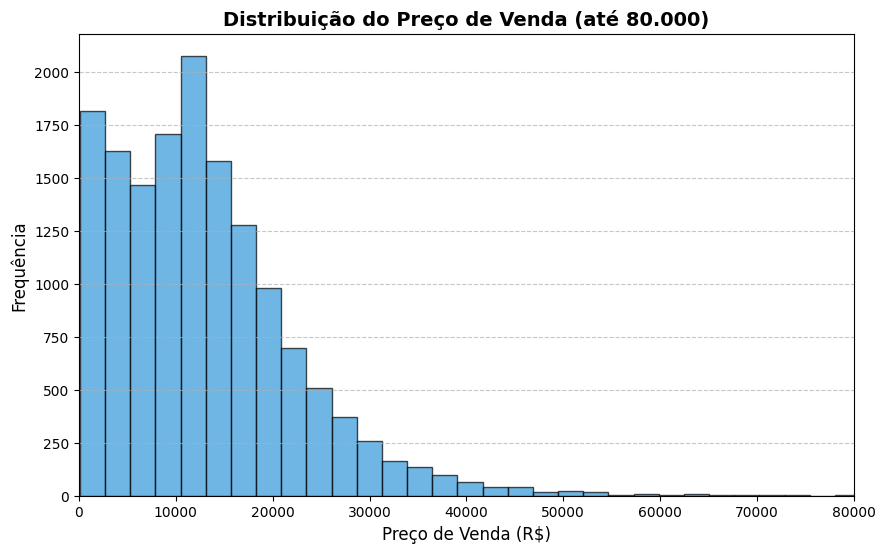

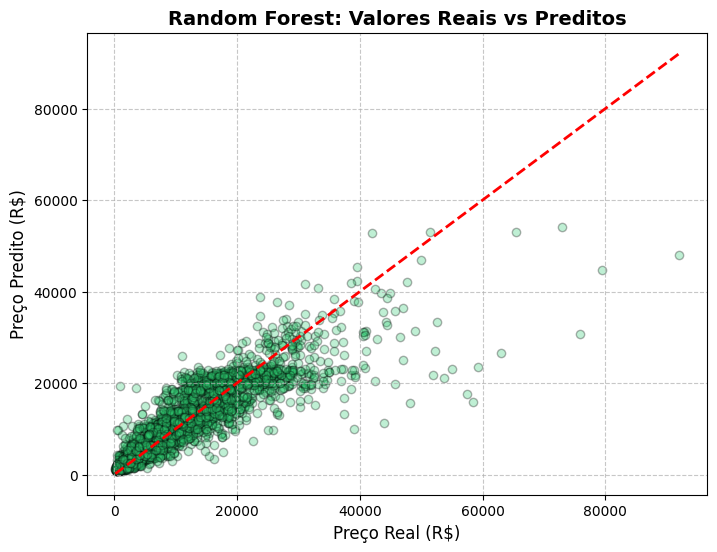

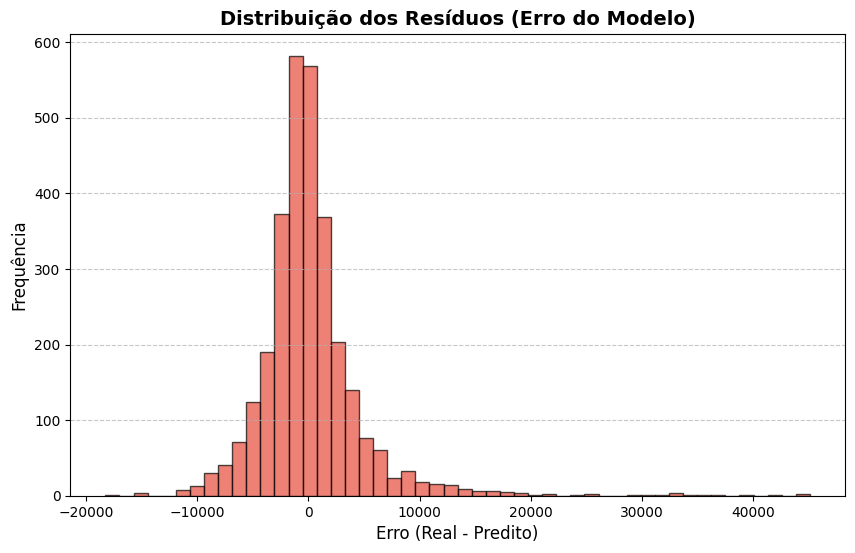

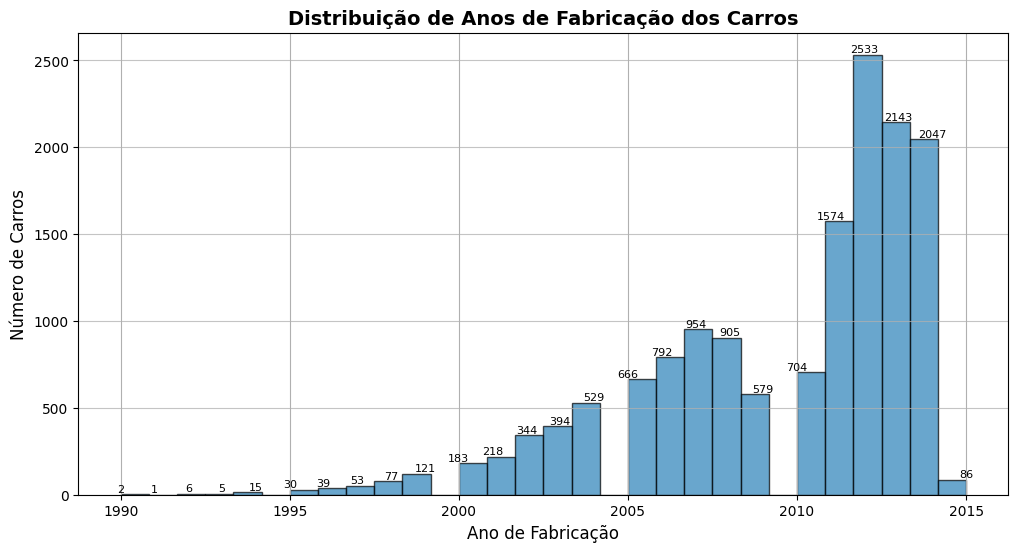

In [132]:

# ============================================================
# PASSO 18 - Gráficos melhorados
# ============================================================

# 1) Distribuição do preço (target) limitado até 80.000
plt.figure(figsize=(10,6))
plt.hist(y, bins=50, edgecolor='black', color='#3498db', alpha=0.7)
plt.title("Distribuição do Preço de Venda (até 80.000)", fontsize=14, fontweight="bold")
plt.xlabel("Preço de Venda (R$)", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.xlim(0, 80000)  # limita até 80 mil
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 2) Real x Predito (Random Forest)
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.3, color="#2ecc71", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
plt.xlabel("Preço Real (R$)", fontsize=12)
plt.ylabel("Preço Predito (R$)", fontsize=12)
plt.title("Random Forest: Valores Reais vs Preditos", fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# 3) Distribuição dos resíduos
residuos = y_test - y_pred_rf
plt.figure(figsize=(10,6))
plt.hist(residuos, bins=50, edgecolor='black', color='#e74c3c', alpha=0.7)
plt.title("Distribuição dos Resíduos (Erro do Modelo)", fontsize=14, fontweight="bold")
plt.xlabel("Erro (Real - Predito)", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
#plt.axvline(0, color="black", linestyle="--", linewidth=2)  # linha no zero
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 4) Distribuição dos anos dos carros
plt.figure(figsize=(12,6))
df['year'].hist(bins=30, edgecolor='black', alpha=0.7, color='#2980b9')

plt.title("Distribuição de Anos de Fabricação dos Carros", fontsize=14, fontweight="bold")
plt.xlabel("Ano de Fabricação", fontsize=12)
plt.ylabel("Número de Carros", fontsize=12)
plt.grid(axis='y', alpha=0.75)

# Adiciona contagem em cima de cada barra
for i in df['year'].value_counts().sort_index().index:
    count = df['year'].value_counts().sort_index()[i]
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=8)

plt.show()




**Interpretação:** use os gráficos para verificar: (1) skew da distribuição de preços; (2) se o Real×Predito está concentrado na linha identidade (bom sinal); (3) se resíduos estão centrados em 0 e se há outliers (4) idade dos carros



## Passo 19 — Importância das features (Permutation Importance)

**O que vamos fazer:** calcular a importância das features por permutação — permuta cada feature e mede quanto a métrica piora. Essa técnica é model-agnostic e reflete importância real para preditor já treinado.

Top 15 Features mais importantes:


,Feature,Importância
6,odometer,0.499974
1,make,0.324120
3,body,0.208332
2,model,0.059243
10,vehicle_age,0.037595
0,year,0.037023
5,condition,0.024651
9,state,0.001653
4,transmission,0.000519
8,interior,0.000351


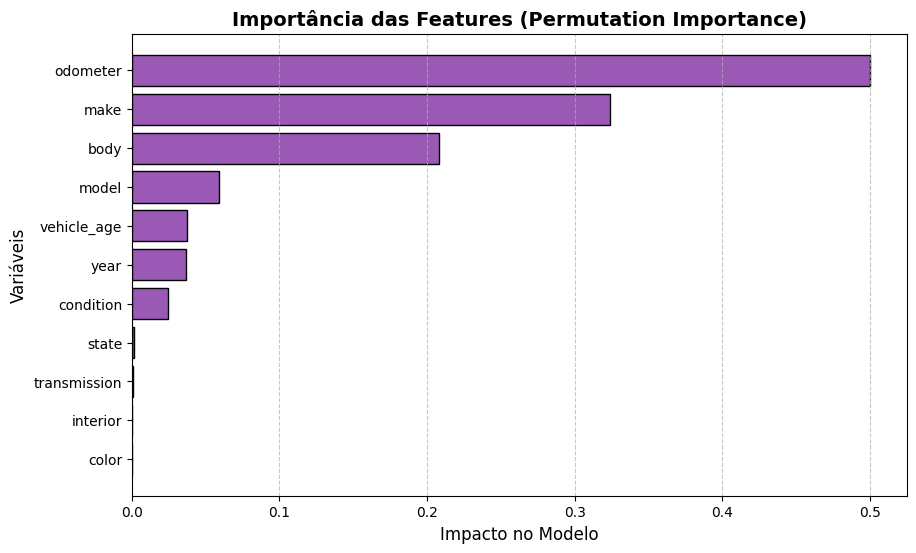

In [133]:

# ============================================================
# PASSO 19 - Importância das Features (melhorado)
# ============================================================
from sklearn.inspection import permutation_importance

# Calcular importância por permutação
result = permutation_importance(final_model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Organizar resultados em DataFrame
importances = pd.DataFrame({
    "Feature": X_test.columns,
    "Importância": result.importances_mean
}).sort_values(by="Importância", ascending=False)

# Exibir top 15
print("Top 15 Features mais importantes:")
display(importances.head(15))

# Plot das top 15 features
plt.figure(figsize=(10,6))
plt.barh(importances["Feature"][:15], importances["Importância"][:15], color="#9b59b6", edgecolor="black")
plt.gca().invert_yaxis()  # inverte para mostrar a mais importante no topo
plt.title("Importância das Features (Permutation Importance)", fontsize=14, fontweight="bold")
plt.xlabel("Impacto no Modelo", fontsize=12)
plt.ylabel("Variáveis", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


**Interpretação:** variáveis com maior aumento de erro ao serem permutadas são as mais importantes. No modelo sem `mmr`, espera-se que `vehicle_age`, `odometer`, `condition` e `make` estejam entre as mais relevantes.

## Conclusão e recomendações finais

- O MVP final é o **Random Forest** treinado sem `mmr`. Métricas principais: **MAE = R$ 2.892,55**, **RMSE = R$ 4.678,24**, **R² = 0.7506**.  
- `mmr` foi removida por apresentar correlação ≈ 0.98 com `sellingprice` (data leakage).  
- Recomendações para próximos passos:
  1. Treinar com a base completa (100%) e validar com cross‑validation.  
  2. Testar modelos adicionais (XGBoost/LightGBM) e hyperparameter tuning.  
  3. Experimentar transformação logarítmica no target para reduzir skew.  
  4. Recolher variáveis extras (histórico de manutenção, acidentes) para melhorar explicabilidade.

---

**Instruções para Colab:** faça upload deste notebook no Colab e execute célula por célula. Se quiser que eu inclua algum bloco extra (ex.: validação cruzada ou tuning), me diga e eu adiciono.
